To create a classification model for the PathMNIST dataset (224x224 size) from the MedMNIST v2 library, you can follow these steps using PyTorch. The model will be based on a Convolutional Neural Network (CNN) and will be built to handle the dataset's requirements.

In [ ]:
!pip install torch torchvision medmnist

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from medmnist import PathMNIST
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=bf8b6a8f72b504c2b04efe3b7943e4a893913a156118a31581ef6537a3c1d922
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
# Load the PathMNIST dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained model mean/std
])

# Load the dataset
train_dataset = PathMNIST(split='train', download=True, transform=transform)
val_dataset = PathMNIST(split='val', download=True, transform=transform)
test_dataset = PathMNIST(split='test', download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 206M/206M [00:13<00:00, 15.4MB/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
class PathMNISTClassifier(nn.Module):
    def __init__(self, num_classes=9):  # PathMNIST has 9 classes
        super(PathMNISTClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Replace the final fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Iterate over data
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Reshape labels to 1D if necessary
            labels = labels.view(-1) #This line ensures 'labels' is a 1D tensor

            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        # Print epoch statistics
        avg_loss = running_loss / len(train_loader)
        accuracy = (correct_preds / total_preds) * 100
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


In [ ]:
def evaluate_model(model, val_loader, device):
    model.to(device)
    model.eval()

    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    accuracy = (correct_preds / total_preds) * 100
    print(f"Validation Accuracy: {accuracy:.2f}%")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PathMNISTClassifier(num_classes=9)  # PathMNIST has 9 categories
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 2813/2813 [03:16<00:00, 14.33it/s]


Epoch 1/10, Loss: 0.4663, Accuracy: 83.76%


Epoch 2/10: 100%|██████████| 2813/2813 [03:05<00:00, 15.19it/s]


Epoch 2/10, Loss: 0.2642, Accuracy: 90.73%


Epoch 3/10: 100%|██████████| 2813/2813 [03:03<00:00, 15.35it/s]


Epoch 3/10, Loss: 0.2023, Accuracy: 93.02%


Epoch 4/10: 100%|██████████| 2813/2813 [03:02<00:00, 15.45it/s]


Epoch 4/10, Loss: 0.1606, Accuracy: 94.38%


Epoch 5/10: 100%|██████████| 2813/2813 [03:03<00:00, 15.35it/s]


Epoch 5/10, Loss: 0.1291, Accuracy: 95.41%


Epoch 6/10: 100%|██████████| 2813/2813 [03:03<00:00, 15.34it/s]


Epoch 6/10, Loss: 0.1077, Accuracy: 96.24%


Epoch 7/10: 100%|██████████| 2813/2813 [03:06<00:00, 15.07it/s]


Epoch 7/10, Loss: 0.0931, Accuracy: 96.68%


Epoch 8/10: 100%|██████████| 2813/2813 [03:05<00:00, 15.15it/s]


Epoch 8/10, Loss: 0.0778, Accuracy: 97.29%


Epoch 9/10: 100%|██████████| 2813/2813 [03:04<00:00, 15.25it/s]


Epoch 9/10, Loss: 0.0693, Accuracy: 97.58%


Epoch 10/10: 100%|██████████| 2813/2813 [03:04<00:00, 15.27it/s]

Epoch 10/10, Loss: 0.0588, Accuracy: 97.92%


Evaluating: 100%|██████████| 225/225 [00:04<00:00, 49.13it/s]


Validation Accuracy: 480.21%


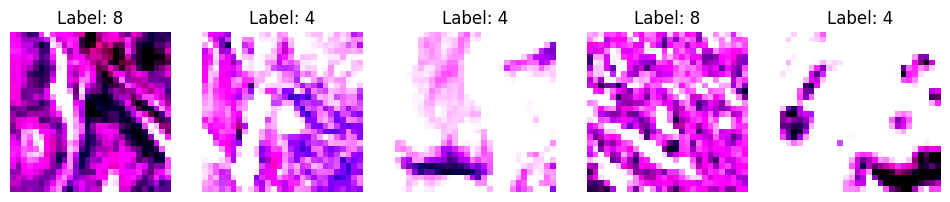

In [ ]:
def plot_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy().transpose((0, 2, 3, 1))  # Convert to HWC format

    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.show()


evaluate_model(model, test_loader, device)

torch.save(model.state_dict(), 'pathmnist_model.pth')

plot_images(test_loader)